<a href="https://colab.research.google.com/github/BugraAlptekinSari/landuse-classifier/blob/main/LandUseClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [ ]:
# Import the necessary modules
from osgeo import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import joblib

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Generating Features

In [ ]:
# Open the GeoTIFF files using GDAL
training2D_label = gdal.Open("< path to .tif file containing labels >").ReadAsArray()
training2D_data = gdal.Open('<path to .tif file containing color bands>').ReadAsArray()

# Transpose the images for whatever reason
training2D_label = np.swapaxes(training2D_label, 0, 1)
training2D_data = np.swapaxes(training2D_data, 0, 2)

In [ ]:
from skimage.io import imshow
from skimage.filters.rank import entropy
from skimage.morphology import disk

In [ ]:
def get_entropy(img):
  out = []
  for i in range(4):
    out.append(entropy(img[:,:,i], disk(10)))
  return out

def convert_to_1D_df(img_list):
  out_list = []
  for i in range(4):
    out_list.append( pd.DataFrame(img_list[i].reshape(img_list[i].shape[0] * img_list[i].shape[1])))
  out_df = pd.concat(out_list,axis=1)
  out_df.columns = ['Conv_Blue', 'Conv_Green', 'Conv_Red', 'Conv_NIR']
  return out_df

In [ ]:
entr_training_list = get_entropy(training2D_data)

/usr/local/lib/python3.8/dist-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (10916), equivalent to an approximate bitdepth of 13.4.
  image, selem, out, mask, n_bins = _preprocess_input(image, selem,
/usr/local/lib/python3.8/dist-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (11378), equivalent to an approximate bitdepth of 13.5.
  image, selem, out, mask, n_bins = _preprocess_input(image, selem,
/usr/local/lib/python3.8/dist-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (14104), equivalent to an approximate bitdepth of 13.8.
  image, selem, out, mask, n_bins = _preprocess_input(image, selem,
/usr/local/lib/python3.8/dist-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number 

In [ ]:
entr_training_list[0].shape

(855, 1131)

In [ ]:
training2D_data.reshape(training2D_data.shape[0] * training2D_data.shape[1], -1).shape

(967005, 4)

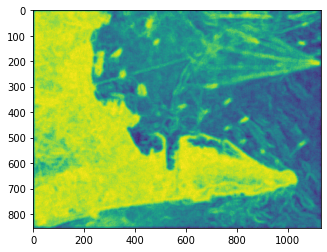

In [ ]:
plt.imshow(entr_training_list[3], interpolation='nearest')

In [ ]:
entr_training_df = convert_to_1D_df(entr_training_list)

In [ ]:
df_train_data = pd.DataFrame(training2D_data.reshape(training2D_data.shape[0] * training2D_data.shape[1], -1))

In [ ]:
df_train_data = pd.concat([df_train_data , entr_training_df],axis=1)

In [ ]:
df_train_data.columns=['Blue', 'Green', 'Red', 'NIR','Conv_Blue', 'Conv_Green', 'Conv_Red', 'Conv_NIR']
df_train_data

,Blue,Green,Red,NIR,Conv_Blue,Conv_Green,Conv_Red,Conv_NIR
0,0,0,0,0,5.869034,5.980145,5.980145,6.002367
1,1997,1982,1860,3672,6.064115,6.184115,6.211663,6.211663
2,1950,1906,1776,3335,6.199776,6.327049,6.320186,6.388457
3,1933,1886,1742,3390,6.334148,6.457106,6.440439,6.530063
4,2162,2035,2173,3605,6.462914,6.591797,6.514874,6.659143
...,...,...,...,...,...,...,...,...
967000,2358,2125,1996,1893,6.139337,5.969537,6.339337,6.366335
967001,2375,2085,1948,1897,6.100274,5.939281,6.246189,6.354685
967002,2356,2044,1952,1877,6.037956,5.856372,6.176548,6.269863
967003,2331,2050,1961,1884,5.938563,5.796566,6.086112,6.216307


In [ ]:
def calc_NDVI(red, nir):
  return (nir - red)/(nir + red)

def calc_NDWI(green, nir):
  return (green - nir)/(nir + green)

In [ ]:
df_train_data["NDVI"] = df_train_data.apply(lambda x:calc_NDVI(x.Red,x.NIR),axis=1)

<ipython-input-59-d47dd91e20dc>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (nir - red)/(nir + red)


In [ ]:
df_train_data["NDWI"] = df_train_data.apply(lambda x:calc_NDWI(x.Green,x.NIR),axis=1)

<ipython-input-59-d47dd91e20dc>:5: RuntimeWarning: invalid value encountered in double_scalars
  return (green - nir)/(nir + green)


In [ ]:
df_train_data = df_train_data.fillna(0)
df_train_data

,Blue,Green,Red,NIR,Conv_Blue,Conv_Green,Conv_Red,Conv_NIR,NDVI,NDWI
0,0,0,0,0,5.869034,5.980145,5.980145,6.002367,0.000000,0.000000
1,1997,1982,1860,3672,6.064115,6.184115,6.211663,6.211663,0.327549,-0.298903
2,1950,1906,1776,3335,6.199776,6.327049,6.320186,6.388457,0.305028,-0.272658
3,1933,1886,1742,3390,6.334148,6.457106,6.440439,6.530063,0.321122,-0.285064
4,2162,2035,2173,3605,6.462914,6.591797,6.514874,6.659143,0.247837,-0.278369
...,...,...,...,...,...,...,...,...,...,...
967000,2358,2125,1996,1893,6.139337,5.969537,6.339337,6.366335,-0.026485,0.057740
967001,2375,2085,1948,1897,6.100274,5.939281,6.246189,6.354685,-0.013264,0.047212
967002,2356,2044,1952,1877,6.037956,5.856372,6.176548,6.269863,-0.019587,0.042591
967003,2331,2050,1961,1884,5.938563,5.796566,6.086112,6.216307,-0.020026,0.042196


In [ ]:
df_train_data.to_pickle('drive/<path to data directory>/conv_train.pkl')

## Load Pre-Processed Pickle

In [ ]:
df_train_data = pd.read_pickle('drive/<path to data directory>/conv_train.pkl')

In [ ]:
df_train_data

,Blue,Green,Red,NIR,Conv_Blue,Conv_Green,Conv_Red,Conv_NIR,NDVI,NDWI
0,0,0,0,0,5.869034,5.980145,5.980145,6.002367,0.000000,0.000000
1,1997,1982,1860,3672,6.064115,6.184115,6.211663,6.211663,0.327549,-0.298903
2,1950,1906,1776,3335,6.199776,6.327049,6.320186,6.388457,0.305028,-0.272658
3,1933,1886,1742,3390,6.334148,6.457106,6.440439,6.530063,0.321122,-0.285064
4,2162,2035,2173,3605,6.462914,6.591797,6.514874,6.659143,0.247837,-0.278369
...,...,...,...,...,...,...,...,...,...,...
967000,2358,2125,1996,1893,6.139337,5.969537,6.339337,6.366335,-0.026485,0.057740
967001,2375,2085,1948,1897,6.100274,5.939281,6.246189,6.354685,-0.013264,0.047212
967002,2356,2044,1952,1877,6.037956,5.856372,6.176548,6.269863,-0.019587,0.042591
967003,2331,2050,1961,1884,5.938563,5.796566,6.086112,6.216307,-0.020026,0.042196


In [ ]:
df_train_label = pd.DataFrame(training2D_label.reshape(training2D_label.shape[0] * training2D_label.shape[1], -1))
del training2D_data
del training2D_label

In [ ]:
df_train_label.columns=["Code"]

In [ ]:
train_water_index = (df_train_label["Code"] == 80)

In [ ]:
df_train_data_nw = df_train_data.loc[~train_water_index, :]
df_train_label_nw = df_train_label.loc[~train_water_index, :]

In [ ]:
train_nw_building_index = df_train_label_nw["Code"] == 50

In [ ]:
df_train_data_plant = df_train_data_nw.loc[~train_nw_building_index, :]
df_train_label_plant = df_train_label_nw.loc[~train_nw_building_index, :]

## Data Split (No Water)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train_data_nw, df_train_label_nw, stratify=df_train_label_nw, test_size=0.30)

### No water and building only

In [ ]:
X_train_building, X_test_building, y_train_building, y_test_building = train_test_split(df_train_data_nw, train_nw_building_index, stratify=train_nw_building_index, test_size=0.30)

### No Water, No Building

In [ ]:
X_train_plant, X_test_plant, y_train_plant, y_test_plant = train_test_split(df_train_data_plant, df_train_label_plant, stratify=df_train_label_plant, test_size=0.30)

## Data Split (Water Only)

In [ ]:
X_train_water, X_test_water, y_train_water, y_test_water = train_test_split(df_train_data, train_water_index, stratify=train_water_index, test_size=0.30)

# SGD Classifier

In [ ]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))

In [ ]:
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def plot_confusion_matrix(conf_mtrx, classes, cmap=plt.cm.Blues):
    num_class = conf_mtrx.shape[0]
    
    fig, ax = plt.subplots()
    im = ax.imshow(conf_mtrx, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(num_class), yticks=np.arange(num_class),
           xticklabels=classes, yticklabels=classes, 
           ylabel='True label', xlabel='Predicted label')

    middle_threshold = conf_mtrx.max() / 2.
    for row in range(num_class):
        for col in range(num_class):
            ax.text(col, row, format(conf_mtrx[row, col], '.0f'), ha="center", va="center",
                    color="white" if conf_mtrx[row, col] > middle_threshold else "black")
    fig.tight_layout()
    plt.show()

In [ ]:
cm = confusion_matrix(y_test,y_pred)
report = classification_report(y_test,y_pred,zero_division=True)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       425
          10       0.74      0.04      0.08     17408
          20       0.31      0.05      0.08      4713
          30       0.52      0.71      0.60     32483
          40       0.00      0.00      0.00      1304
          50       0.71      0.91      0.80     43019
          60       0.03      0.01      0.01      4504
          80       0.99      0.99      0.99    185723
          90       0.00      0.00      0.00       523

    accuracy                           0.85    290102
   macro avg       0.45      0.38      0.36    290102
weighted avg       0.85      0.85      0.83    290102



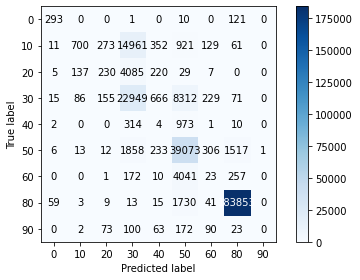

In [ ]:
plot_confusion_matrix(cm, np.unique(y_test))

# Random Forest (Building only w/o water)

In [ ]:
building_clf = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3), RandomForestClassifier(max_depth=100, random_state=0))

In [ ]:
building_clf.fit(X_train_building,y_train_building)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=100, random_state=0))])

In [ ]:
y_pred_building = building_clf.predict(X_test_building)

In [ ]:
cm = confusion_matrix(y_test_building,y_pred_building)
report = classification_report(y_test_building,y_pred_building,zero_division=True)
print(report)

              precision    recall  f1-score   support

       False       0.93      0.90      0.91     61361
        True       0.86      0.90      0.88     43019

    accuracy                           0.90    104380
   macro avg       0.89      0.90      0.90    104380
weighted avg       0.90      0.90      0.90    104380



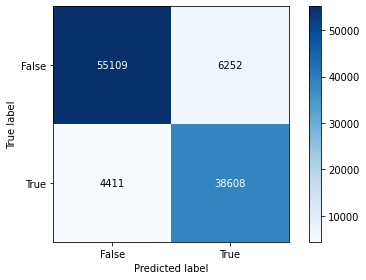

In [ ]:
plot_confusion_matrix(cm, np.unique(y_test_building))

## Save/Load

In [ ]:
building_clf_name = "drive/< path to saves directory >/RandomForest_100D_Building.sav"

In [ ]:
joblib.dump(building_clf, building_clf_name)

In [ ]:
building_clf = joblib.load(building_clf_name)

# Random Forest (No Building or Water)

In [ ]:
plant_clf = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3), RandomForestClassifier(max_depth=100, random_state=0))

In [ ]:
plant_clf.fit(X_train_plant,y_train_plant)

/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=100, random_state=0))])

In [ ]:
y_pred_plant = plant_clf.predict(X_test_plant)

In [ ]:
cm = confusion_matrix(y_test_plant,y_pred_plant)
report = classification_report(y_test_plant,y_pred_plant,zero_division=True)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       425
          10       0.80      0.72      0.76     17408
          20       0.77      0.72      0.74      4713
          30       0.80      0.88      0.84     32483
          40       0.81      0.23      0.35      1304
          60       0.79      0.74      0.77      4504
          90       0.71      0.47      0.57       524

    accuracy                           0.80     61361
   macro avg       0.80      0.68      0.71     61361
weighted avg       0.80      0.80      0.79     61361



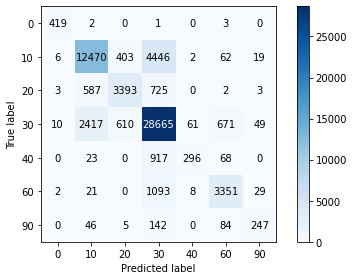

In [ ]:
plot_confusion_matrix(cm, np.unique(y_test_building))

## Save/Load

In [ ]:
plant_clf_name = "drive/< path to saves directory >/RandomForest_100D_plant.sav"

In [ ]:
joblib.dump(plant_clf, plant_clf_name)

In [ ]:
plant_clf = joblib.load(plant_clf_name)

# Non-linear SVM (No Water)

In [ ]:
clf = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3), SGDClassifier(max_iter=10000, tol=1e-9))

In [ ]:
clf.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('sgdclassifier', SGDClassifier(max_iter=10000, tol=1e-09))])

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
report = classification_report(y_test,y_pred,zero_division=True)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       425
          10       0.68      0.65      0.66     17408
          20       0.66      0.51      0.58      4713
          30       0.69      0.74      0.72     32483
          40       0.28      0.01      0.01      1304
          50       0.82      0.89      0.86     43019
          60       0.59      0.27      0.37      4504
          90       0.28      0.04      0.07       524

    accuracy                           0.75    104380
   macro avg       0.62      0.51      0.53    104380
weighted avg       0.73      0.75      0.73    104380



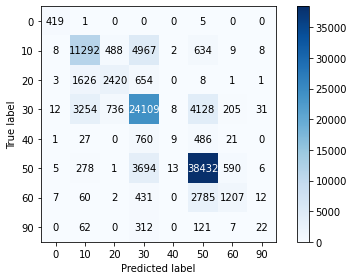

In [ ]:
plot_confusion_matrix(cm, np.unique(y_test))

## Save/Load Model

In [ ]:
clf_name = "drive/< path to saves directory >/PSVM_10k_ENTR2.sav"

In [ ]:
joblib.dump(clf, clf_name)

In [ ]:
clf = joblib.load(clf_name)

# Poly SVM (Building Only with no water)

In [ ]:
building_clf = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3), SGDClassifier(max_iter=10000, tol=1e-9))

In [ ]:
building_clf.fit(X_train_building,y_train_building)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('sgdclassifier', SGDClassifier(max_iter=10000, tol=1e-09))])

In [ ]:
y_pred_building = building_clf.predict(X_test_building)

In [ ]:
cm = confusion_matrix(y_test_building,y_pred_building)
report = classification_report(y_test_building,y_pred_building,zero_division=True)
print(report)

              precision    recall  f1-score   support

       False       0.92      0.88      0.90     61361
        True       0.84      0.89      0.86     43019

    accuracy                           0.88    104380
   macro avg       0.88      0.88      0.88    104380
weighted avg       0.88      0.88      0.88    104380



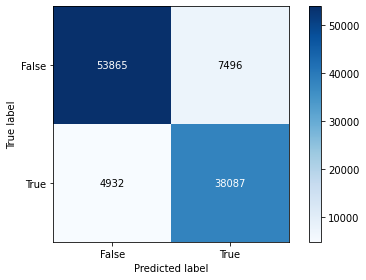

In [ ]:
plot_confusion_matrix(cm, np.unique(y_test_building))

## Save/Load

In [ ]:
building_clf_name = "drive/< path to saves directory >/PSVM_10k_ENTR_Building.sav"

In [ ]:
joblib.dump(building_clf, building_clf_name)

In [ ]:
building_clf = joblib.load(building_clf_name)

# Poly SVM (Water Only)

In [ ]:
water_clf = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), SGDClassifier(max_iter=10000, tol=1e-6))

In [ ]:
water_clf.fit(X_train_water,y_train_water)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(max_iter=10000, tol=1e-06))])

In [ ]:
y_pred_water = water_clf.predict(X_test_water)

In [ ]:
cm = confusion_matrix(y_test_water,y_pred_water)
report = classification_report(y_test_water,y_pred_water,zero_division=True)
print(report)

              precision    recall  f1-score   support

       False       0.98      0.99      0.98    104379
        True       1.00      0.99      0.99    185723

    accuracy                           0.99    290102
   macro avg       0.99      0.99      0.99    290102
weighted avg       0.99      0.99      0.99    290102



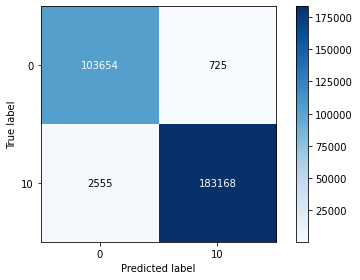

In [ ]:
plot_confusion_matrix(cm, np.unique(y_test))

## Save Model

In [ ]:
water_clf_name = "drive/< path to saves directory >/Poly_2_SVM_10k_ENTR_WATER.sav"

In [ ]:
joblib.dump(water_clf, water_clf_name)

## Load Model

In [ ]:
water_clf = joblib.load(water_clf_name)

# KNN Classifier

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
clf = KNeighborsClassifier(n_neighbors=1)

In [ ]:
from scipy import stats
filtered_train_data = df_train_data[(np.abs(stats.zscore(df_train_data)) < 3).all(axis=1)]
filtered_train_label = df_train_label[(np.abs(stats.zscore(df_train_data)) < 3).all(axis=1)]

In [ ]:
scores = cross_val_score(clf, filtered_train_data, np.ravel(filtered_train_label), cv=5)
acc = scores.mean()

In [ ]:
clf.fit(filtered_train_data,filtered_train_label)

KNeighborsClassifier(n_neighbors=1)

# Poly SVM w/o split (Water Only)

In [ ]:
water_clf = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), SGDClassifier(max_iter=10000, tol=1e-9))

In [ ]:
water_clf.fit(df_train_data,train_water_index)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('sgdclassifier', SGDClassifier(max_iter=10000, tol=1e-09))])

## Save/Load

In [ ]:
water_clf_name = "drive/< path to saves directory >/PSVM_10k_ENTR_WATER_no_split.sav"

In [ ]:
joblib.dump(water_clf, water_clf_name) # save

In [ ]:
water_clf = joblib.load(water_clf_name) # load

# Poly SVM w/o split (No Water)

In [ ]:
clf = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3), SGDClassifier(max_iter=10000, tol=1e-9))

In [ ]:
clf.fit(df_train_data_nw,df_train_label_nw)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('sgdclassifier', SGDClassifier(max_iter=10000, tol=1e-09))])

## Save/Load

In [ ]:
clf_name = "drive/< path to saves directory >/PSVM_10k_ENTR_no_split.sav"

In [ ]:
joblib.dump(clf, clf_name) # save

In [ ]:
clf = joblib.load(clf_name) # load

# Prediction

In [ ]:
test2D_data = gdal.Open("/content/drive/< path to test data >").ReadAsArray()
test2D_data = np.swapaxes(test2D_data, 0, 2)

In [ ]:
test_entropy_img = get_entropy(test2D_data)

/usr/local/lib/python3.8/dist-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (6748), equivalent to an approximate bitdepth of 12.7.
  image, selem, out, mask, n_bins = _preprocess_input(image, selem,
/usr/local/lib/python3.8/dist-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (7128), equivalent to an approximate bitdepth of 12.8.
  image, selem, out, mask, n_bins = _preprocess_input(image, selem,
/usr/local/lib/python3.8/dist-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of bins (7875), equivalent to an approximate bitdepth of 12.9.
  image, selem, out, mask, n_bins = _preprocess_input(image, selem,
/usr/local/lib/python3.8/dist-packages/skimage/filters/rank/generic.py:264: UserWarning: Bad rank filter performance is expected due to a large number of 

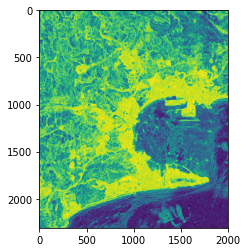

In [ ]:
plt.imshow(test_entropy_img[0], interpolation='nearest')

In [ ]:
df_test_data = pd.DataFrame(test2D_data.reshape(test2D_data.shape[0] * test2D_data.shape[1], -1))
df_test_data = pd.concat([df_test_data , convert_to_1D_df(test_entropy_img)],axis=1)
df_test_data.columns=['Blue', 'Green', 'Red', 'NIR','Conv_Blue', 'Conv_Green', 'Conv_Red', 'Conv_NIR']

In [ ]:
df_test_data["NDVI"] = df_test_data.apply(lambda x:calc_NDVI(x.Red,x.NIR),axis=1)

<ipython-input-59-d47dd91e20dc>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (nir - red)/(nir + red)


In [ ]:
df_test_data["NDWI"] = df_test_data.apply(lambda x:calc_NDWI(x.Green,x.NIR),axis=1)

<ipython-input-59-d47dd91e20dc>:5: RuntimeWarning: invalid value encountered in double_scalars
  return (green - nir)/(nir + green)


In [ ]:
df_test_data = df_test_data.fillna(0)
df_test_data

,Blue,Green,Red,NIR,Conv_Blue,Conv_Green,Conv_Red,Conv_NIR,NDVI,NDWI
0,0,0,0,0,5.449318,5.417598,5.599426,5.757923,0.000000,0.000000
1,1938,1880,1683,3362,5.701468,5.576824,5.789017,6.011663,0.332805,-0.282717
2,1943,1874,1661,3388,5.797370,5.688514,5.967869,6.188457,0.342048,-0.287723
3,1959,1876,1690,3354,5.862239,5.861406,6.081111,6.330063,0.329897,-0.282600
4,1943,1873,1696,3305,5.920380,5.919612,6.085072,6.459143,0.321736,-0.276555
...,...,...,...,...,...,...,...,...,...,...
4620304,1880,1590,1366,1235,4.478595,4.156351,4.042419,3.932423,-0.050365,0.125664
4620305,1891,1594,1369,1237,4.497150,4.195457,4.014470,3.886612,-0.050652,0.126104
4620306,1879,1591,1375,1242,4.441791,4.127229,3.957339,3.816333,-0.050822,0.123191
4620307,1879,1584,1378,1242,4.403864,4.153208,3.943920,3.813927,-0.051908,0.121019


In [ ]:
df_test_data.to_pickle('drive/< path to saves directory >/entr_test.pkl')

In [ ]:
del test2D_data
del test_entropy_img

## Load Pre-Processed

In [ ]:
# Use this function to load the pre-processed
df_test_data = pd.read_pickle('drive/< path to saves directory >/entr_test.pkl')

In [ ]:
df_test_data

,Blue,Green,Red,NIR,Conv_Blue,Conv_Green,Conv_Red,Conv_NIR,NDVI,NDWI
0,0,0,0,0,5.449318,5.417598,5.599426,5.757923,0.000000,0.000000
1,1938,1880,1683,3362,5.701468,5.576824,5.789017,6.011663,0.332805,-0.282717
2,1943,1874,1661,3388,5.797370,5.688514,5.967869,6.188457,0.342048,-0.287723
3,1959,1876,1690,3354,5.862239,5.861406,6.081111,6.330063,0.329897,-0.282600
4,1943,1873,1696,3305,5.920380,5.919612,6.085072,6.459143,0.321736,-0.276555
...,...,...,...,...,...,...,...,...,...,...
4620304,1880,1590,1366,1235,4.478595,4.156351,4.042419,3.932423,-0.050365,0.125664
4620305,1891,1594,1369,1237,4.497150,4.195457,4.014470,3.886612,-0.050652,0.126104
4620306,1879,1591,1375,1242,4.441791,4.127229,3.957339,3.816333,-0.050822,0.123191
4620307,1879,1584,1378,1242,4.403864,4.153208,3.943920,3.813927,-0.051908,0.121019


## Predict (Water -> Rest)

### Water

In [ ]:
test_water_index = water_clf.predict(df_test_data)

In [ ]:
df_test_data_nw = df_test_data.loc[~test_water_index,:]

### Rest

In [ ]:
output = clf.predict(df_test_data_nw)

### Combine

In [ ]:
df_out = pd.read_csv('/content/drive/< path to submission file >')

In [ ]:
df_out["Code"] = 80 

In [ ]:
df_out["Code"][~test_water_index] = output

## Predict (Water -> Build -> Rest)

### Water

In [ ]:
test_water_index = water_clf.predict(df_test_data)

In [ ]:
np.save('/content/drive/< path to saves directory >/intermediate_data/test_water_index.npy', test_water_index)

In [ ]:
test_water_index = np.load('/content/drive/< path to saves directory >/intermediate_data/test_water_index.npy')

### Building

In [ ]:
df_test_data_nw = df_test_data.loc[~test_water_index,:]

In [ ]:
test_nw_building_index = building_clf.predict(df_test_data_nw)

In [ ]:
np.save('/content/drive/< path to saves directory >/intermediate_data/test_nw_building_index.npy', test_nw_building_index)

In [ ]:
test_nw_building_index = np.load('/content/drive/< path to saves directory >/intermediate_data/test_nw_building_index.npy')

### Plant

In [ ]:
df_test_data_plant = df_test_data_nw.loc[~test_nw_building_index,:]

In [ ]:
plant_res = plant_clf.predict(df_test_data_plant)

In [ ]:
np.save('/content/drive/< path to saves directory >/intermediate_data/plant_res.npy', plant_res)

In [ ]:
plant_res = np.load('/content/drive/< path to saves directory >/intermediate_data/plant_res.npy')

### Combine

In [ ]:
df_out = pd.read_csv('/content/drive/< path to example submission file>')

In [ ]:
df_out["Code"] = 80 

In [ ]:
df_out["Code"][~test_water_index] = 50

In [ ]:
test_water_index[~test_water_index] = test_nw_building_index

In [ ]:
df_out["Code"][~test_water_index] = plant_res

## Submit output

In [ ]:
df_out.to_csv("drive/< path to saves directory >/submission.csv",index=False)
df_out.to_csv("submission.csv",index=False)

In [ ]:
!mkdir -p ~/.kaggle
!cp drive/< directory containing kaggle token >/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle competitions submit -c ayb-ceng463-machine-learning-project-fall-2022 -f submission.csv -m "Water (Poly 2 SVM) -> Rest (P3 SVM 1e-9 tol)"

100% 47.4M/47.4M [00:01<00:00, 34.4MB/s]
Successfully submitted to AYBÜ CENG463 Machine Learning Project, Fall 2022